In [1]:
# Импорт библиотек
import os
import time

import GTU
import KU_TU
import mat_properties as prop
import numpy as n
import pandas as pd
import SP
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel(
    "streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)
############################################################
# Теплосеть и перекидка температуры воздуха
gas_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWINB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SWOUT", "T"] = SP.Tset(Tnv)[0]
water_streams.at["SWIN-TURB", "T"] = water_streams.at["SWINB", "T"]
water_streams.at["SP2-WOUT", "T"] = water_streams.at["SWOUT", "T"]
############################################################


# Основные эффективности оборудования
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99


# Параметры, отвечающие за процесс расчета
Calcmethod = "hybr"
Calctolerance = 10**-2
Maxiterations_KU_TU = 20
Maxiterations_cotel = 4
Maxiterations_turbine = 30

# Параметры режима работы ПГУ
# Расчет для минимума нагрузки
Сalculate_minimum = True
# Расчет для работы с теплофикацией
Teplo = int(True)
# Отбор пара высокго давления или доля или кг/с
steamVD_fraction_to_turbine = 1
steamVD_to_turbine = 0


# Состав газов в номинале в ГТУ
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = list(gas_streams0.loc["GTU-PEVD", "N2":"Ar"])
gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Задание ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")


# Расчет ГТУ
Gas_turbine_res = Gas_turbine.calc()

# Запись данных об электричестве
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]

# Запись данных о газе на выходе из ГТУ
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at["GTU-KU", "H"] = gas0.p_t(
    gas_streams.at["GTU-KU", "P"], gas_streams.at["GTU-KU", "T"])["h"]
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0)

# Параметры газа на входе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"] = Gas_turbine_composition.loc[
    "Fraction", "N2":"Ar"]

# Состав газов при частичной нагрузке
list(gas_streams.loc["GTU-PEVD", "N2":"Ar"])
fractiongas = list(gas_streams.loc["GTU-PEVD", "N2":"Ar"])

gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)


# Class KU+TU
KU_and_TU = KU_TU.ku_tu(
    gas0,
    gas1,
    water,
    gas_streams0,
    gas_streams,
    water_streams0,
    water_streams,
    heaters,
    electric,
    "PEVD-DROSVD",
    "PPND-DROSND",
    "DROSVD-TURBVD",
    "DROSND-TURBND",
    Calcmethod,
    KPD_SP,
    KPD_KN,
    KPD_to,
    KPD_PN,
    steamVD_fraction_to_turbine,
    steamVD_to_turbine,
)


start_time = time.time()

# Расчет КУ и ТУ
KU_and_TU.calculate(
    Teplo,
    Calctolerance,
    Maxiterations_KU_TU,
    Maxiterations_cotel,
    Maxiterations_turbine,
)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

        
        

    ########################ОГРАНИЧЕНИЯ НА РАБОТУ ПГУ########################
    # ЕСЛИ ТЕПЛОФИКАЦИЯ (из документов по ПГУ-220Т)
    # Gк_мин=4,44 кг/с вроде
    # Nтурбины мин = 17,6 МВт (примерно 25%)
    # Максимальноа давление в отборах СП 0,245, 0,198 МПа (Теплофикационная паровая турбина Т-63/76-8.8 для серии ПГУ-230)
    # ДЛЯ ВСЕХ РЕЖИМОВ (Из Трухния по ПГУ-450Т)
    # Gвд_мин=25% от номинала
    # Gнд_мин = 50% от номинала

Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 5.82 сек. ---
dQ/Qsumm -0.0014415661006680818
Fin турбоустановка:--- 0.08 сек. ---
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.7920139551555314
dQ/Q ПЕВД+ИВД+ЭВД -1.5997049418727685
dQ/Q ПЕВД+ИВД+ЭВД 0.7805763477625216
dQ/Q ПЕВД+ИВД+ЭВД -0.3808993689061506
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК -0.009116984399591525
Достигнуто макси

In [14]:
if Сalculate_minimum == True:
    Condition_all=False
    if Teplo==1:
        Condition_Gcnd=water_streams.at['INKOND','G']<=4.44
        Condition_Nturb=electric.at['Turbine','Ni']<=17.6
        Condition_all+=Condition_Gcnd+Condition_Nturb
        print(Condition_Gcnd,Condition_Nturb,Condition_all)
    Condition_Gvd=water_streams.at['PEVD-DROSVD','G']/water_streams0.at['PEVD-DROSVD','G']<=0.25
    Condition_Gnd=water_streams.at['PPND-DROSND','G']/water_streams0.at['PPND-DROSND','G']<=0.5
    Condition_all+=Condition_Gvd+Condition_Gnd
    if Condition_all==True:
        print(Condition_Gvd, Condition_Gnd, Condition_all,GTU_input.at['n',1])

True False True
False False True 1


In [3]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,467.873716,0.1,873.832134,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,308.238383,0.1,696.368111,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,234.042508,0.1,616.084406,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,231.187720,0.1,613.020665,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,172.220478,0.1,550.113684,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,101.153085,0.1,475.118689,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065


In [4]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.592064,8.287594,3424.812929,62.479178,NaN,NaN
IVD-PEVD,300.282445,8.622130,2749.093687,62.479178,NaN,NaN
EVD-IVD,297.955792,8.622130,1333.286288,62.479178,NaN,NaN
PEN-EVD,162.922781,8.622130,692.790594,62.479178,NaN,NaN
BND-PEN,161.145391,0.636455,680.451718,62.479178,NaN,NaN
PPND-DROSND,206.769385,0.630755,2863.852761,14.522513,NaN,NaN
IND-PPND,161.145391,0.636455,2758.694697,14.522513,NaN,NaN
GPK-IND,157.619599,0.636455,665.173004,77.001692,NaN,NaN
GPK-REC,157.619599,0.636455,665.173004,90.409799,NaN,NaN


In [5]:
Errors_water = abs(water_streams - water_streams0) / water_streams0 * 100
Errors_gas = abs(gas_streams - gas_streams0) / gas_streams0 * 100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,0.000000,NaN
ASW-OD,NaN,NaN,NaN,NaN,NaN,NaN
ASW-WOUT,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,1.452400,2.247371,8.607828,NaN,2.181016,NaN
DOOTB1,50.231786,5.270795,80.552707,4.716139,NaN,NaN
DOOTB2,1.481971,2.992029,60.061779,2.851691,23.874438,NaN
DROSND-TURBND,1.608989,0.263778,10.540293,0.487454,2.368145,NaN
DROSVD-ST,NaN,NaN,NaN,NaN,NaN,NaN
DROSVD-TURBVD,1.452400,0.066835,1.420099,NaN,0.080421,NaN
ENDOFVD,1.452400,0.509396,11.370144,NaN,4.225552,NaN


In [6]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,-9999.990000,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065


In [7]:
electric

,Ni,N,KPDm,KPD
PEN,0.770923,0.793994,0.970943,0.712590
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,150.750600,NaN,33.348086
DK,NaN,6.269747,NaN,NaN
Turbine,57.121949,NaN,NaN,NaN
Tots1,37.176140,NaN,NaN,0.848024
Tots2,14.852594,NaN,NaN,0.686611
Tots3,5.100196,NaN,NaN,0.684145
Tots4,-0.006981,NaN,NaN,-0.026532


In [8]:
heaters

,Qw,Qg,KPD
PEVD,42220.686632,42647.158215,0.99
IVD,88459.145580,89352.672303,0.99
EVD,40018.409032,40422.635386,0.99
PPND,1527.159846,1542.585703,0.99
IND,31356.765444,31673.500448,0.99
GPK,37382.186359,37759.784201,0.99
SP2,84.124179,NaN,0.99
SP1,83.832602,NaN,0.99
OD,7.392378,NaN,0.99
NaN,NaN,NaN,NaN


In [9]:
GTU_input

,1,2,3,4,5,6
tair,15,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.592064,8.287594,3424.812929,62.479178,6.743817,NaN
IVD-PEVD,300.282445,8.622130,2749.093687,62.479178,NaN,NaN
EVD-IVD,297.955792,8.622130,1333.286288,62.479178,NaN,NaN
PEN-EVD,162.922781,8.622130,692.790594,62.479178,NaN,NaN
BND-PEN,161.145391,0.636455,680.451718,62.479178,NaN,NaN
PPND-DROSND,206.769385,0.630755,2863.852761,14.522513,6.973779,NaN
IND-PPND,161.145391,0.636455,2758.694697,14.522513,NaN,NaN
GPK-IND,157.619599,0.636455,665.173004,77.001692,NaN,NaN
GPK-REC,157.619599,0.636455,665.173004,90.409799,NaN,NaN


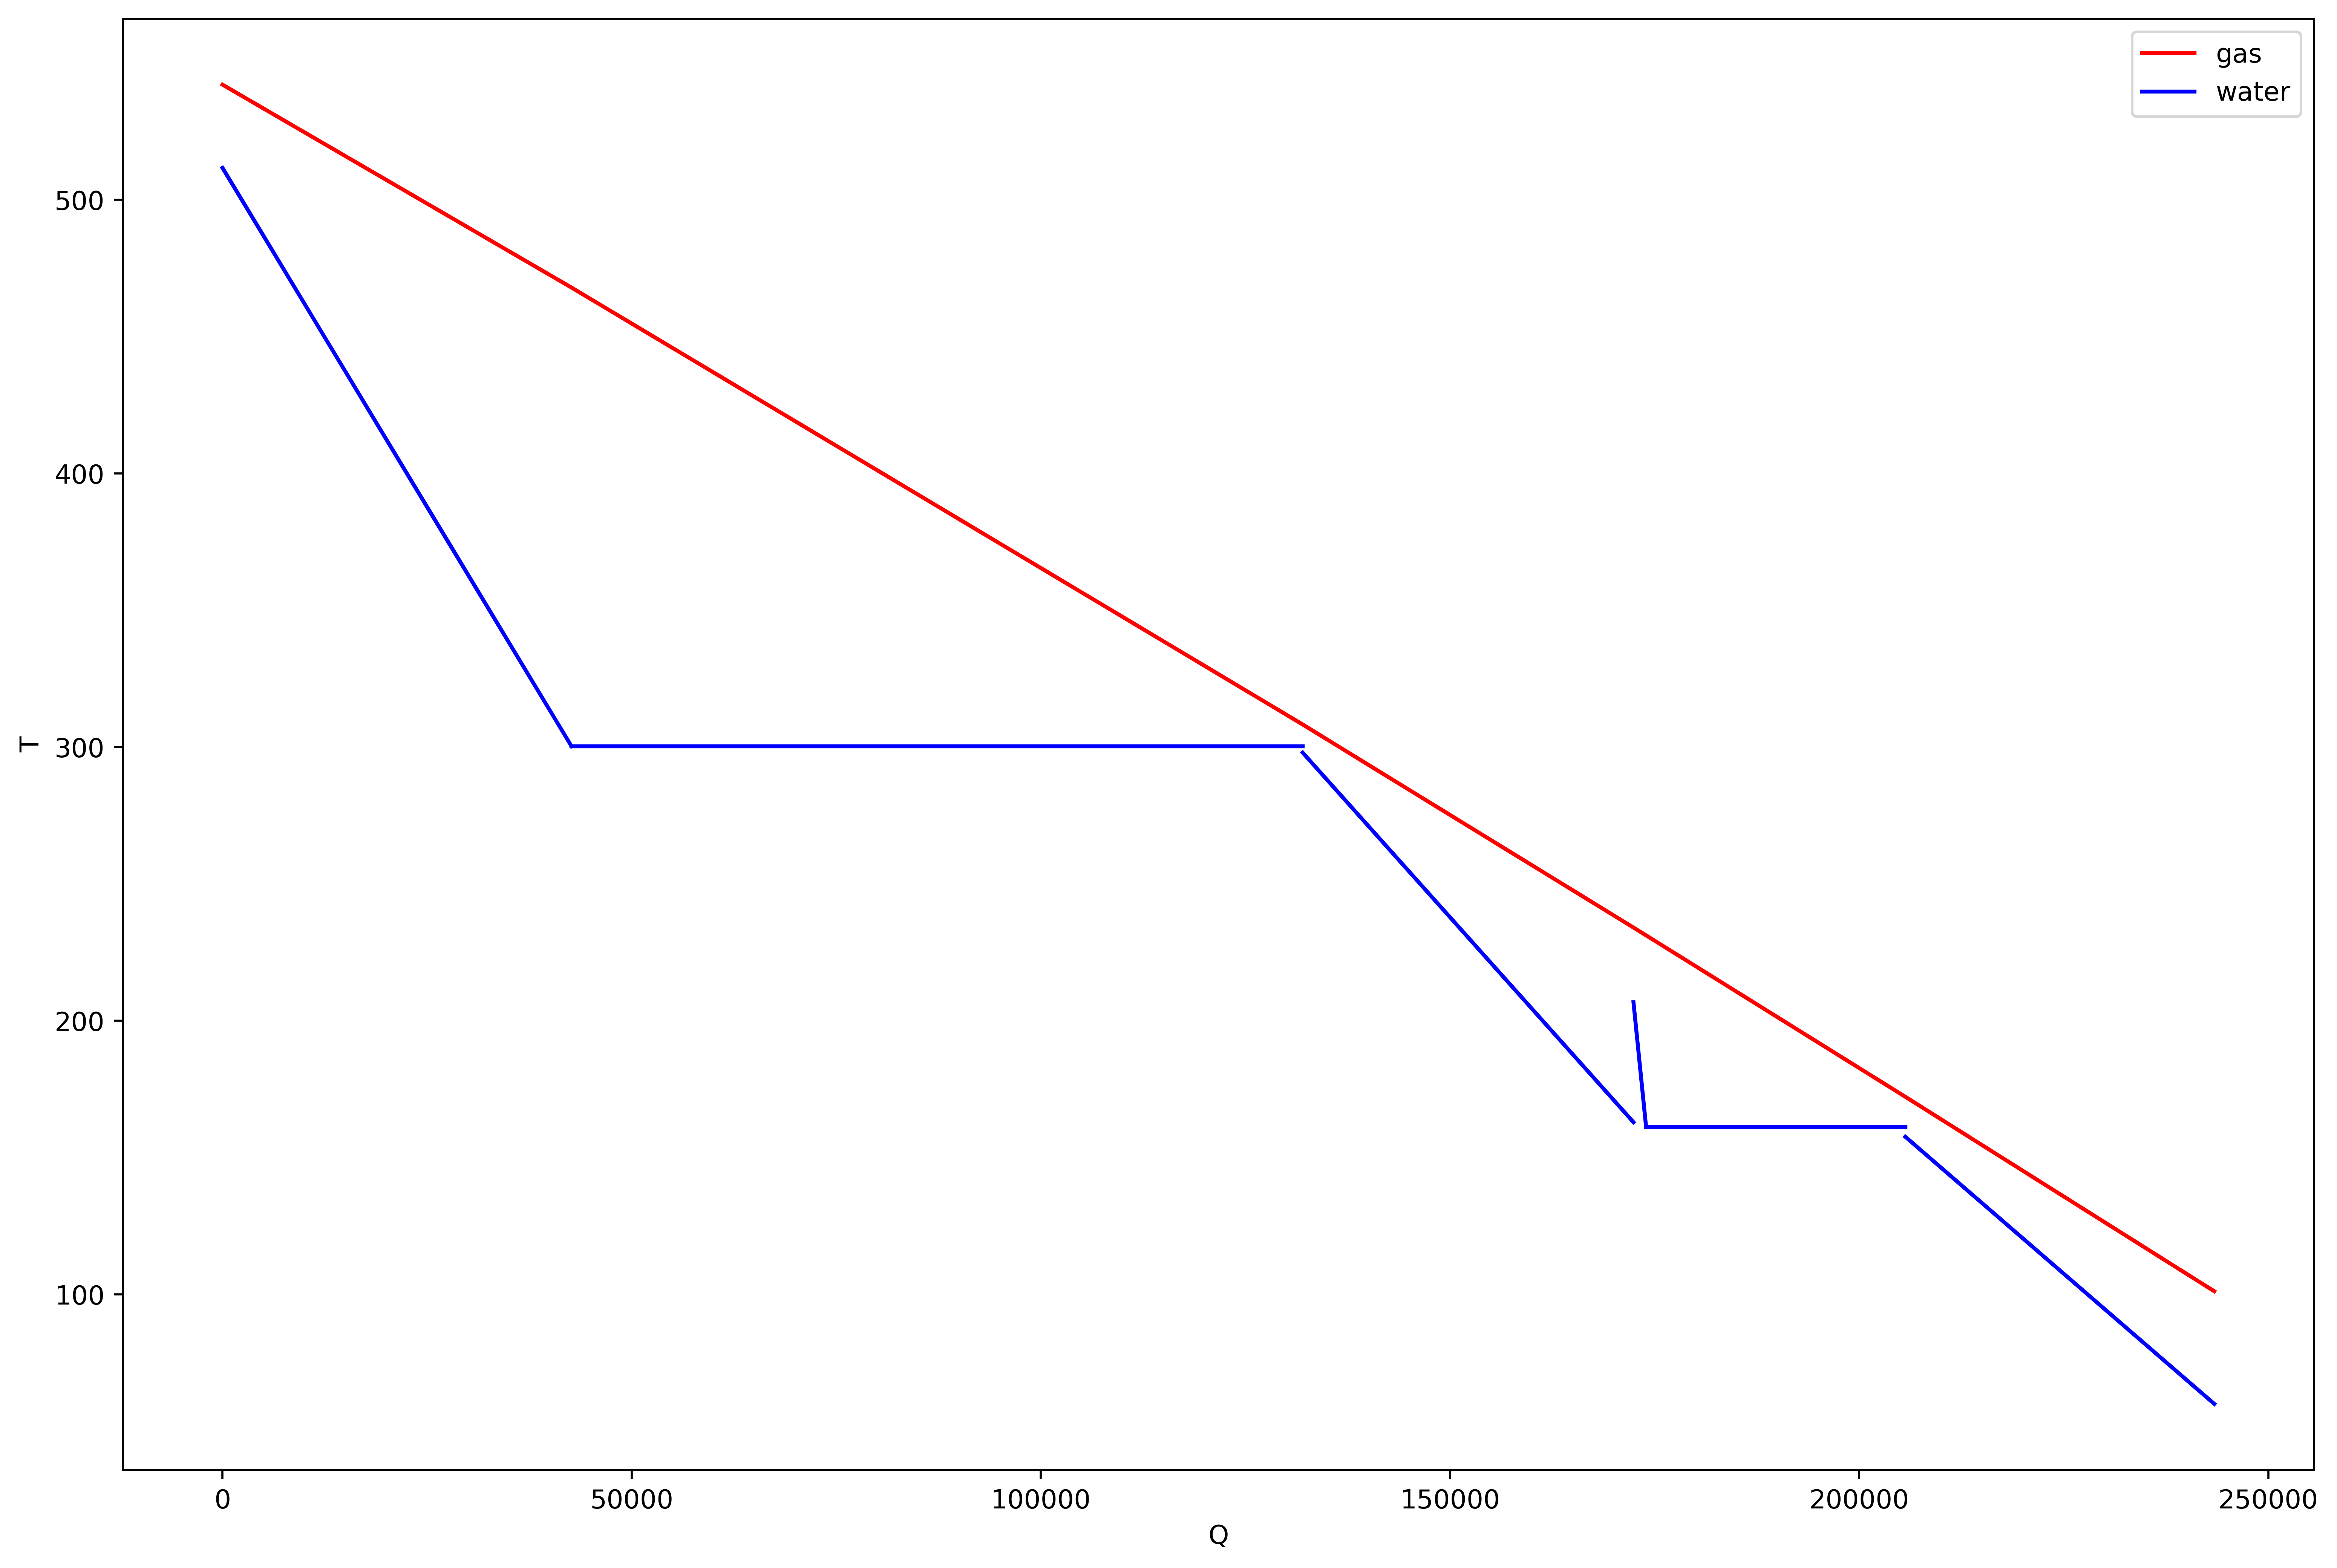

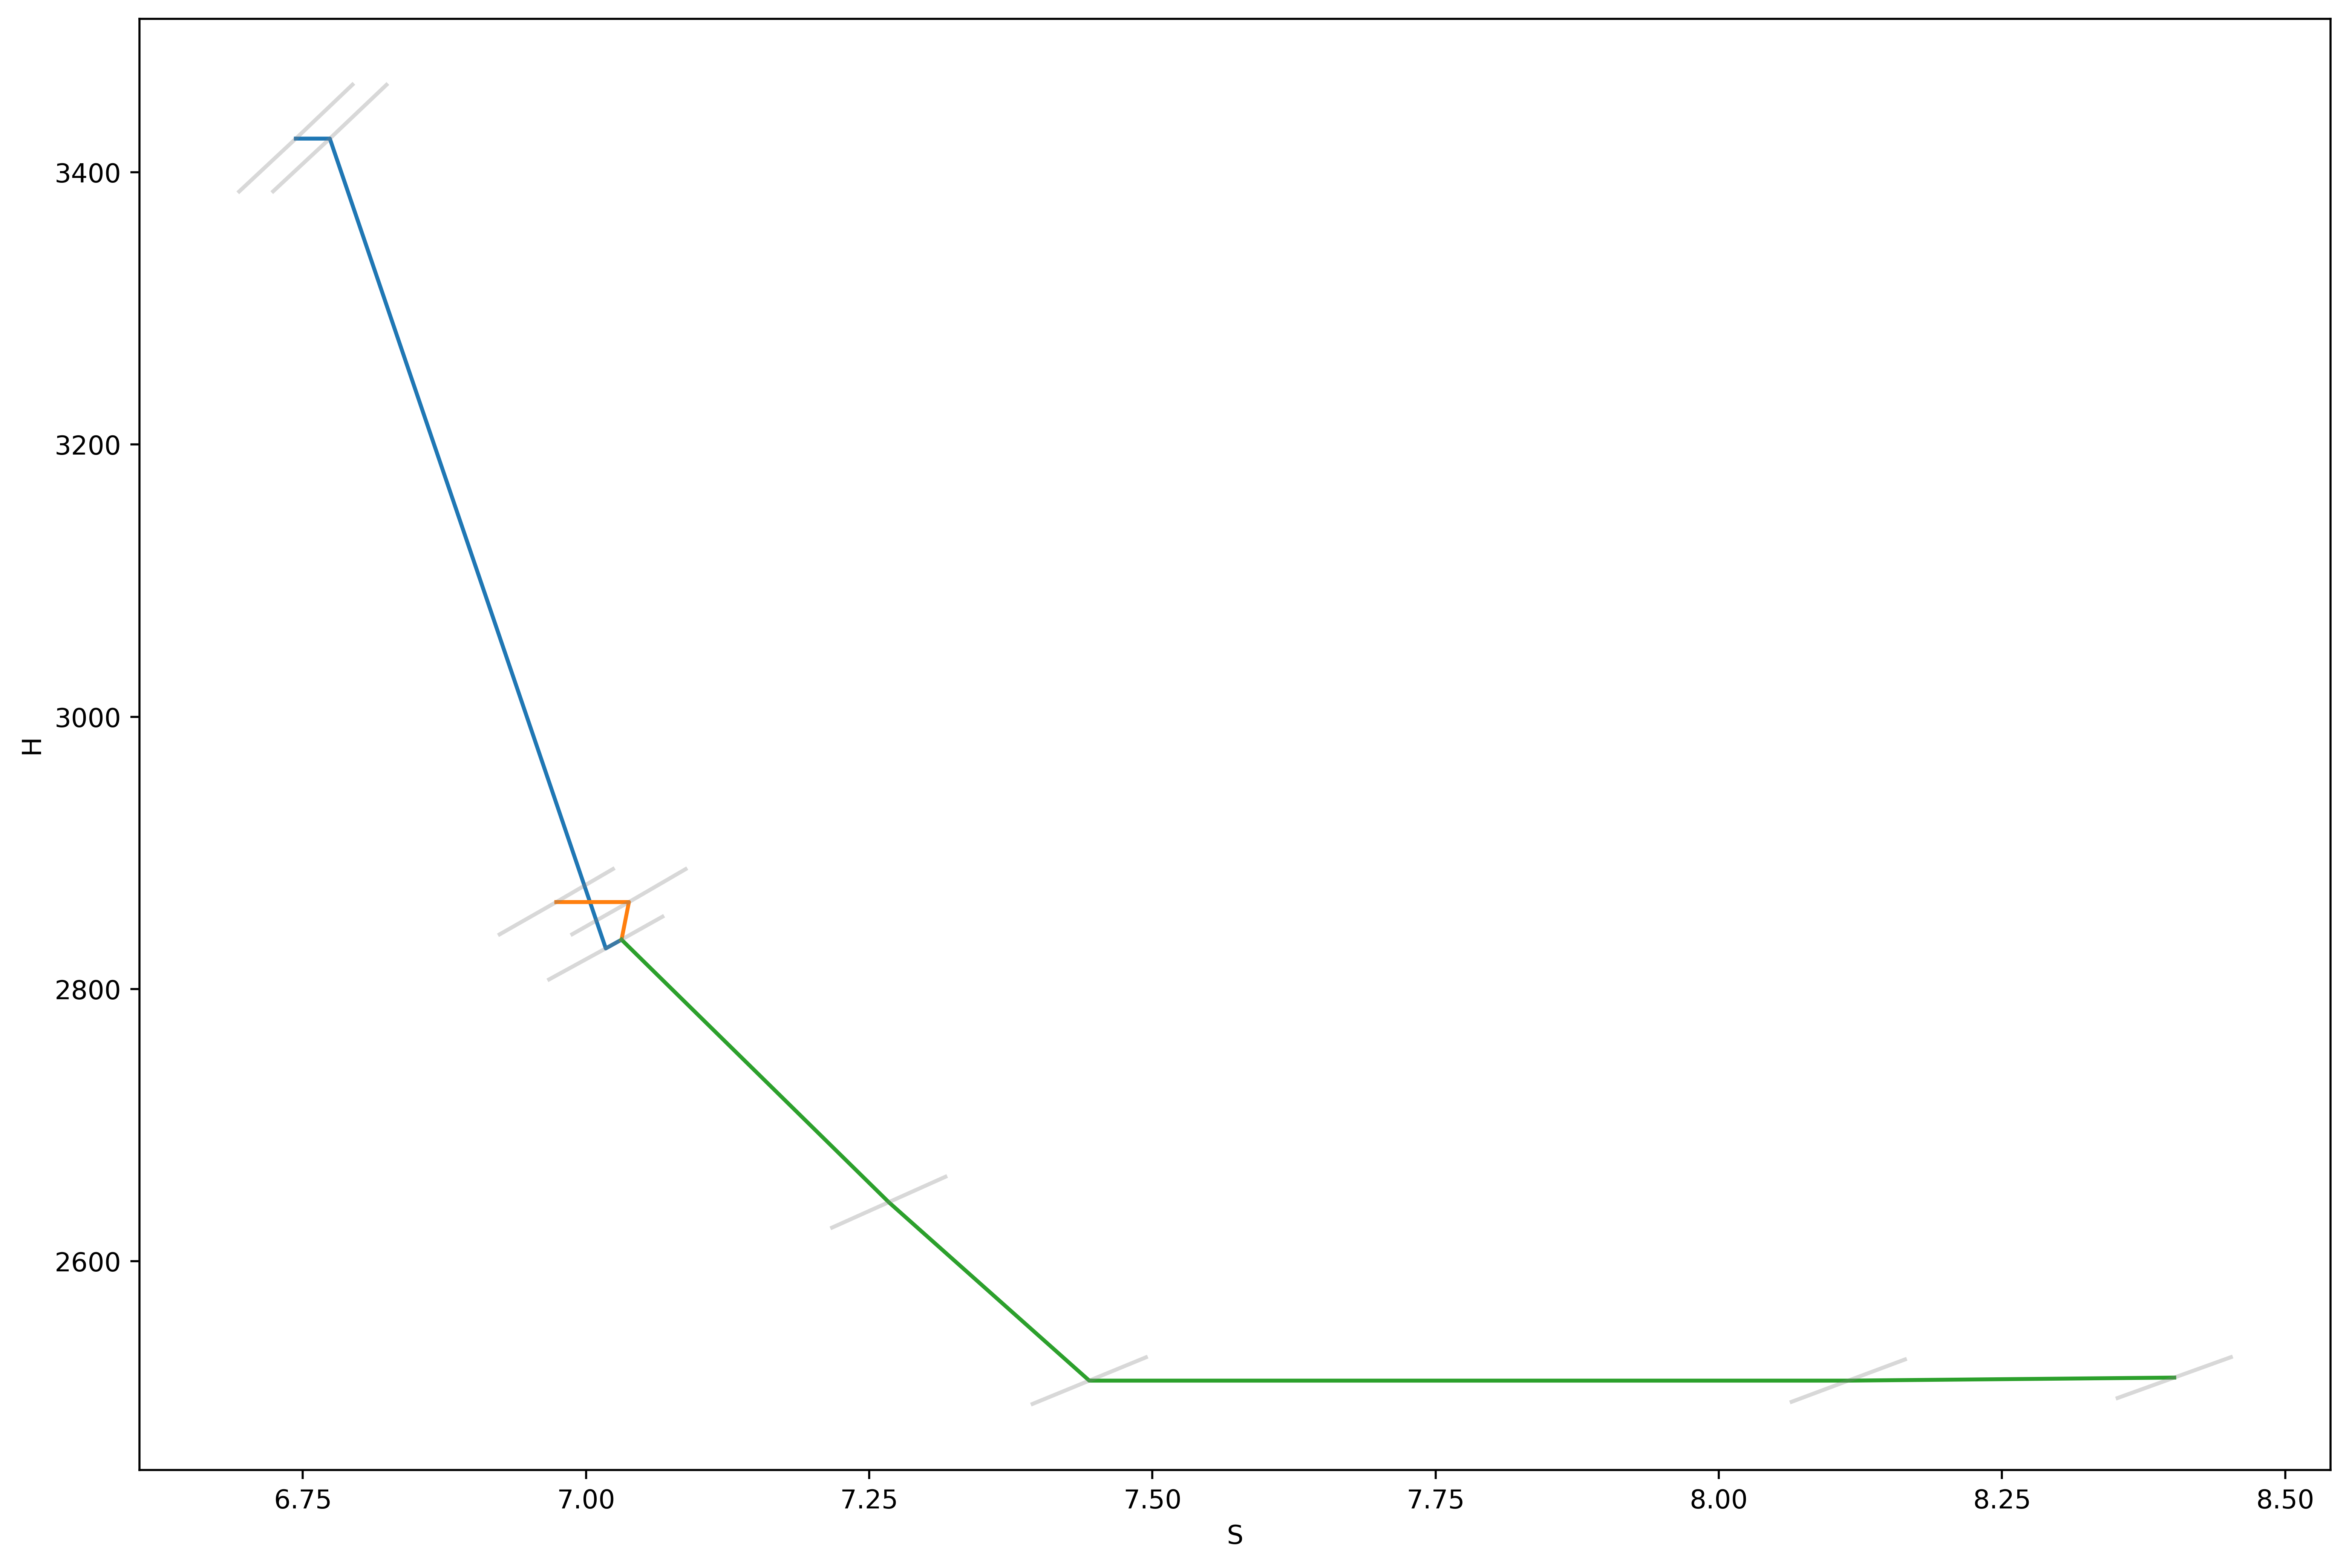

In [10]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)
water_streams

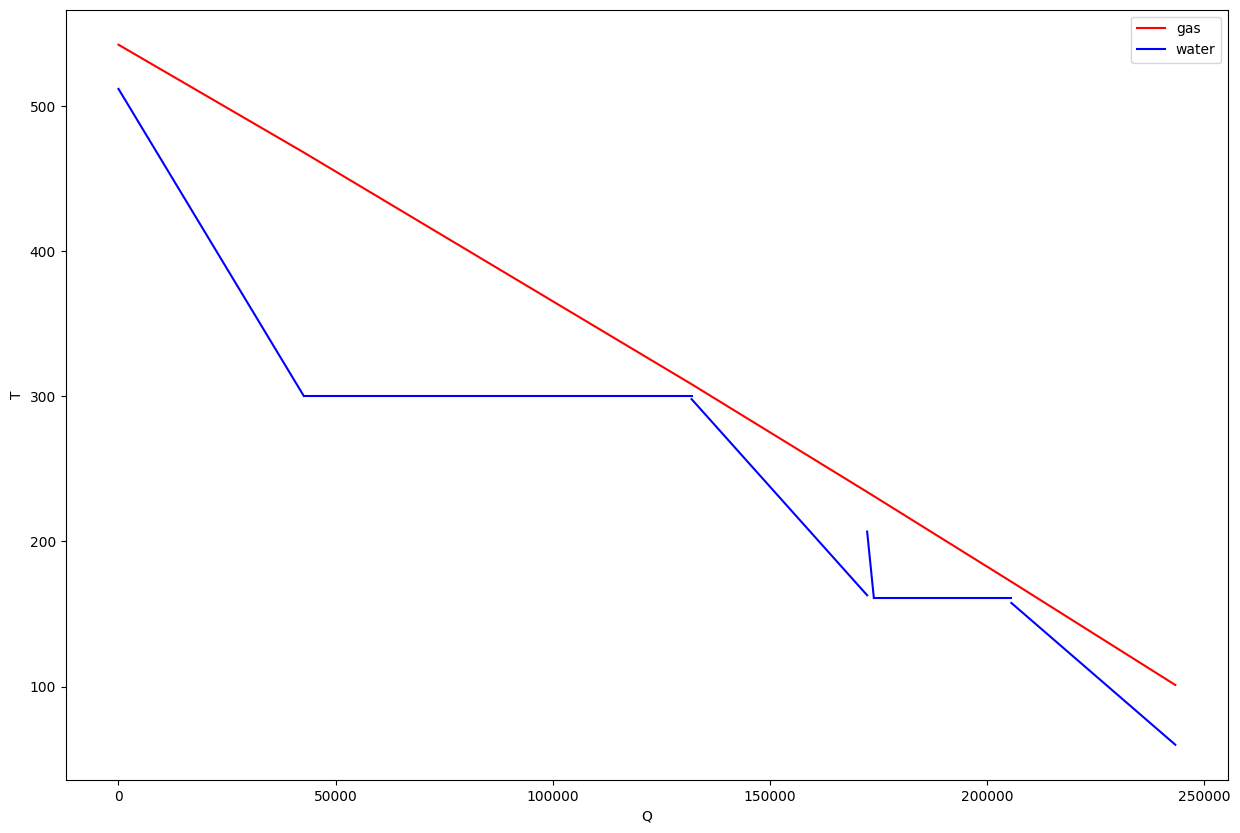

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
Qg = [
    0,
    heaters.loc["PEVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"]
    + heaters.loc["GPK", "Qg"],
]
Qw = [
    0,
    heaters.loc["PEVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"]
    + heaters.loc["GPK", "Qg"],
]
Tg = gas_streams.loc["GTU-PEVD":"GPK-out", "T"]
Tw = [
    water_streams.loc["PEVD-DROSVD", "T"],
    water_streams.loc["IVD-PEVD", "T"],
    water_streams.loc["IVD-PEVD", "T"],
    water_streams.loc["EVD-IVD", "T"],
    water_streams.loc["PEN-EVD", "T"],
    water_streams.loc["PPND-DROSND", "T"],
    water_streams.loc["IND-PPND", "T"],
    water_streams.loc["IND-PPND", "T"],
    water_streams.loc["GPK-REC", "T"],
    water_streams.loc["REC-GPK", "T"],
]
plt.plot(Qg, Tg, color="red")
plt.plot(Qw[0:2], Tw[0:2], color="blue")
plt.plot(Qw[1:3], Tw[1:3], color="blue")
plt.plot(Qw[3:5], Tw[3:5], color="blue")
plt.plot(Qw[5:7], Tw[5:7], color="blue")
plt.plot(Qw[6:8], Tw[6:8], color="blue")
plt.plot(Qw[8:10], Tw[8:10], color="blue")
plt.xlabel("Q")
plt.ylabel("T")
plt.legend(["gas", "water"])
plt.show()

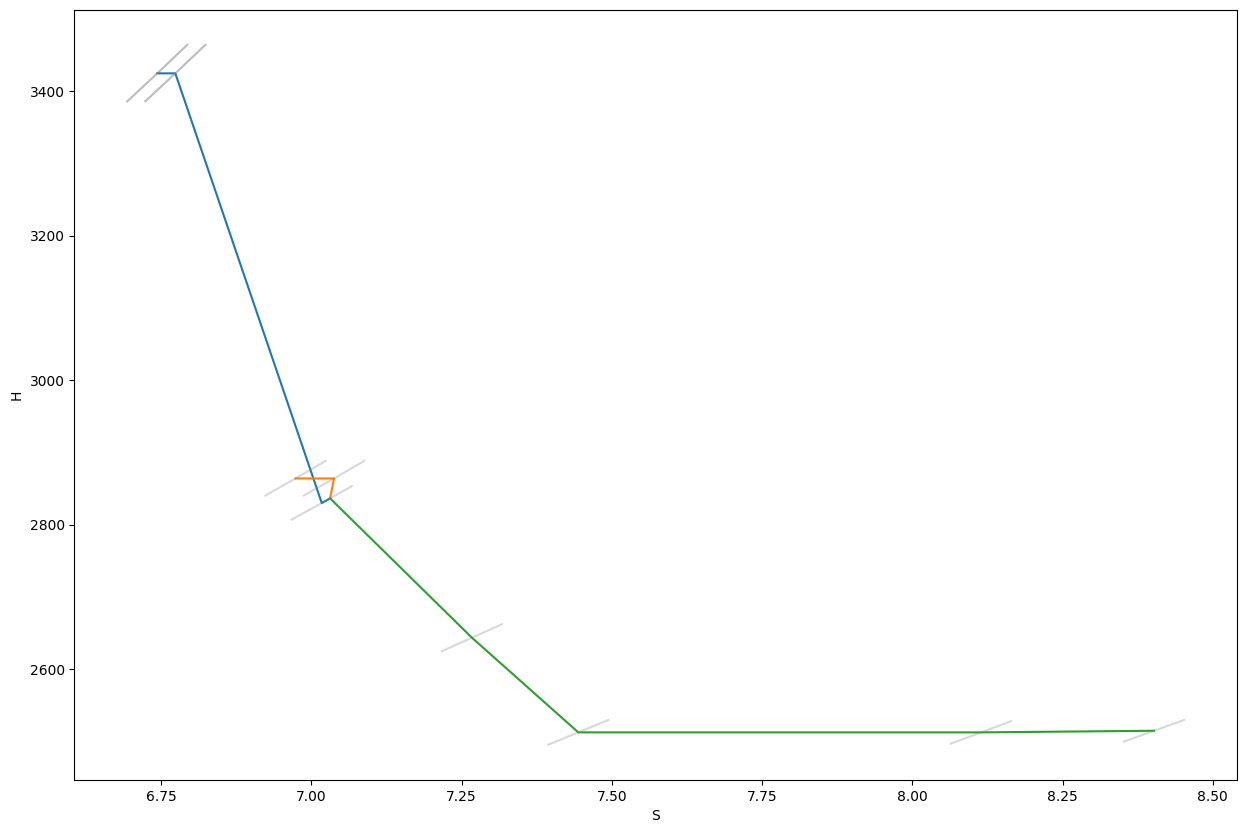

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.592064,8.287594,3424.812929,62.479178,6.743817,NaN
IVD-PEVD,300.282445,8.622130,2749.093687,62.479178,NaN,NaN
EVD-IVD,297.955792,8.622130,1333.286288,62.479178,NaN,NaN
PEN-EVD,162.922781,8.622130,692.790594,62.479178,NaN,NaN
BND-PEN,161.145391,0.636455,680.451718,62.479178,NaN,NaN
PPND-DROSND,206.769385,0.630755,2863.852761,14.522513,6.973779,NaN
IND-PPND,161.145391,0.636455,2758.694697,14.522513,NaN,NaN
GPK-IND,157.619599,0.636455,665.173004,77.001692,NaN,NaN
GPK-REC,157.619599,0.636455,665.173004,90.409799,NaN,NaN


In [12]:
import matplotlib.pyplot as plt

water_streams.at["PEVD-DROSVD", "S"] = water.p_h(
    water_streams.at["PEVD-DROSVD", "P"], water_streams.at["PEVD-DROSVD", "H"]
)["s"]
water_streams.at["PPND-DROSND", "S"] = water.p_h(
    water_streams.at["PPND-DROSND", "P"], water_streams.at["PPND-DROSND", "H"]
)["s"]

plt.figure(figsize=(15, 10))
Hvd = [
    water_streams.at["PEVD-DROSVD", "H"],
    water_streams.at["DROSVD-TURBVD", "H"],
    water_streams.at["ENDOFVD", "H"],
    water_streams.at["SMESHEND", "H"],
]
Svd = [
    water_streams.at["PEVD-DROSVD", "S"],
    water_streams.at["DROSVD-TURBVD", "S"],
    water_streams.at["ENDOFVD", "S"],
    water_streams.at["SMESHEND", "S"],
]
Hsm = [
    water_streams.at["PPND-DROSND", "H"],
    water_streams.at["DROSND-TURBND", "H"],
    water_streams.at["SMESHEND", "H"],
]
Ssm = [
    water_streams.at["PPND-DROSND", "S"],
    water_streams.at["DROSND-TURBND", "S"],
    water_streams.at["SMESHEND", "S"],
]
Hnd = [
    water_streams.at["SMESHEND", "H"],
    water_streams.at["DOOTB2", "H"],
    water_streams.at["DOOTB1", "H"],
    water_streams.at["INCND", "H"],
    water_streams.at["INKOND", "H"],
]
Snd = [
    water_streams.at["SMESHEND", "S"],
    water_streams.at["DOOTB2", "S"],
    water_streams.at["DOOTB1", "S"],
    water_streams.at["INCND", "S"],
    water_streams.at["INKOND", "S"],
]

# Давления
stream = "PEVD-DROSVD"
H1 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S1 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSVD-TURBVD"
H2 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S2 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "ENDOFVD"
H3 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S3 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "PEVD-DROSVD"
H4 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S4 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSVD-TURBVD"
H5 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S5 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "PPND-DROSND"
H6 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S6 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSND-TURBND"
H7 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S7 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]

stream = "DOOTB2"
H8 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S8 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DOOTB1"
H9 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S9 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "INCND"
H10 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S10 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "INKOND"
H11 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S11 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]


plt.plot(Svd, Hvd)
plt.plot(Ssm, Hsm)
plt.plot(Snd, Hnd)
plt.plot(
    S1,
    H1,
    S2,
    H2,
    S3,
    H3,
    S4,
    H4,
    S5,
    H5,
    S6,
    H6,
    S7,
    H7,
    S8,
    H8,
    S9,
    H9,
    S10,
    H10,
    S11,
    H11,
    color="gray",
    alpha=0.3,
)
plt.xlabel("S")
plt.ylabel("H")
plt.show()
water_streams